# Solve a trajectory optimisation problem with bounds and obstacles

In this example, we consider trajectory optimisation with infeasible regions - that is, we want to find a continuous path from an initial point to a target point, while avoiding obstacles in the way and staying within a well-defined region. 

To accomplish this, we chop up the path into discrete intervals and directly optimise over the intermediate values, placing inequality constraints on these intermediate values. The intermediate values we optimise over are called shooting nodes, and the method we use here is called [multiple shooting](https://en.wikipedia.org/wiki/Direct_multiple_shooting_method).

(Note: multiple shooting is a term that is used both in the numerical differential equations literature and in the control literature, the common principle is that the ODE is split into segments, but in control problems the goal of the optimisation is different - to solve an ODE with boundary values on both ends, it is simply an efficient method to accomplish this goal)


Our path can still be described by an ODE, but we now have inequality constraints on the state variables. 
To account for these, we need to unroll the dynamics and directly optimise over the value of the states at discrete time points. To make sure that our pieced-together ODE solution stays smooth, we're adding continuity constraints to our system.

To properly account for inequality constraints on the state variables, we need to unroll the dynamics and optimise over the value of the states at discrete time points. But we still want the trajectory to be continuous, so we are putting an ODE into our constraint function - solved step-wise using a [Diffrax](https://github.com/patrick-kidger/diffrax) ODE solver.

The ODE we're interested in is a system of four first-order ODEs, constructed from a system of two second-order ODEs. It is linear and time-invariant (LTI). We can describe the system's dynamics with

$$\dot{x} = Ax + Bu$$

where $x \in \mathbb{R}^4$ and $u \in \mathbb{R}^2$.

In this problem, we require of any $x(t)$ that it fulfills the continuity constraint $x_i = x(t_i, x_{i-1})$.
The starting condition $x_0$ is given by $[2, 0, 2, 0]$ (so we're at the point $(2, 2)$ with velocity $0$), and the final state to be reached is $[0, 0, 0, 0]$. 

On the way from the starting point to the finish line we want to avoid the obstacles in our way. 
We describe the cylindric obstacle with a radius 
$$r = \sqrt{(x_1 - 1)^2 + (x_3 - 1)^2 - 0.5 \cdot d(x)}$$
where $d$ increases monotonically with time. This is a trick in trajectory optimisation - we want to have an easier life in the future, and therefore we steer away from obstacles early enough. 

We want to do all of the above with velocities $\dot{x}_1$ and $\dot{x_2}$ in the range $\pm 0.2$. 

First, import everything we need

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optimistix as optx
from jaxtyping import Array


jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_disable_jit", True)

### Setting up the LTI system

As a first step, let's describe the dynamical system - this is going to be the most
important part of our constraint function.

In [2]:
class LTISystem(eqx.Module):
    """Defines a simple linear time-invariant system of four first order ODEs with a
    forcing term u(t). The system evolves with

    dx = Ax + Bu.
    """

    A: Array
    B: Array

    def euler_step(self, states__inputs):  # Euler integration
        current_states, current_inputs = states__inputs
        return self.A @ current_states + self.B @ current_inputs


A = jnp.array([[1, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 0, 1]])
B = jnp.array([[0, 0], [1, 0], [0, 0], [0, 1]])
lti_system = LTISystem(A, B)

In [3]:
# TODO: allow constraints to take arguments

### Setting up the constraint function

Note that constraint functions can return a PyTree of values. In this case, each element in each leaf of the PyTree will be considered to represent the output of a constraint function. (In other words, constraint functions, much like minimisation functions, return a single scalar value. This is why we can use them to define level sets - sets of numbers producing identical values of the constraint function.)

PyTrees-of-Arrays can be useful here - because we can pack and unpack them quite intuitively, as seen below.

In [4]:
def make_constraint(system, initial_state, final_state, num_timepoints, centerpoint):
    def constraint(y):
        def _dynamics(_, _y):  # Helper function
            return _, system.euler_step(_y)

        _, evolved_states = jax.lax.scan(_dynamics, None, y)

        xs, _ = y
        # jax.debug.print("first element: \n{}\n", xs[0, :])
        # jax.debug.print("initial state: \n{}\n", initial_state)
        # jax.debug.print("last element: \n{}\n", xs[-1, :])
        # jax.debug.print("final state: \n{}\n", final_state)
        starting_point = xs[0, :] - initial_state
        continuity = xs[1:, :] - evolved_states[:-1, :]
        target_reached = evolved_states[-1, :] - final_state

        equality_constraints = (starting_point, continuity, target_reached)

        # TODO: these are technically bounds
        lower_v1 = 0.2 - xs[:, 1]  # v1 < 0.2
        upper_v1 = 0.2 + xs[:, 1]  # v1 > -0.2
        lower_v3 = 0.2 - xs[:, 3]  # v3 < 0.2
        upper_v3 = 0.2 + xs[:, 3]  # v3 > -0.2
        speed_limit = (lower_v1, upper_v1, lower_v3, upper_v3)

        augmented_radius = 1 + jnp.array([i * 0.1 for i in range(num_timepoints)])
        x_center, y_center = centerpoint
        x_distance = (xs[:, 0] - x_center) ** 2
        y_distance = (xs[:, 2] - y_center) ** 2
        distance = jnp.sqrt(x_distance + y_distance) - 0.5 * augmented_radius

        return equality_constraints, (speed_limit, distance)

    return constraint


num_timepoints = 20
x0 = jnp.array([2.0, 0.0, 2.0, 0.0])
centerpoint = (1.0, 1.0)
constraint = make_constraint(
    system=lti_system,
    initial_state=x0,
    final_state=jnp.zeros(4),
    num_timepoints=num_timepoints,
    centerpoint=centerpoint,
)

Now, since we want to optimise - we are going to need an objective function!

In this case we want to minimise the distance to the center of the obstacle and also
avoid high velocities. Additionally, we only want to exercise as much control as is
absolutely necessary. All deviations are going to carry a quadratic cost.

And last but not least, we need a starting point `y0`.

In [5]:
def objective(states__inputs, args):
    states, inputs = states__inputs
    (state_cost, control_cost), obstacle_center = args

    x_center, y_center = obstacle_center
    x_center = 0  # Monkey patch
    y_center = 0
    x_distance = (states[:, 0] - x_center) ** 2
    y_distance = (states[:, 2] - y_center) ** 2
    distance = jnp.sum(jnp.sqrt(x_distance + y_distance))

    velocities = jnp.sum(states[:, 1] ** 2 + states[:, 3] ** 2)

    return control_cost * jnp.sum(inputs**2) + state_cost * (distance + velocities)


# Define costs and some starting point y0
costs = (10.0, 1.0)
# key, subkey = jr.split(jr.key(0))
# states = jr.uniform(subkey, (num_timepoints, 4), minval=0.0, maxval=2.0)
# states = jnp.sort(states)


states = jnp.broadcast_to(jnp.array([2.0, 0.0, 2.1, 0.0]), (num_timepoints, 4))
# states = jnp.broadcast_to(x0, (num_timepoints, 4))
# states = states + 0.1 * jr.normal(jr.key(0), states.shape)
inputs = jnp.zeros((num_timepoints, 2))
y0 = (states, inputs)

args = (costs, centerpoint)
objective(y0, args)

Array(580., dtype=float64)

In [6]:
equality_constraint, inequality_constraint = constraint(y0)

speed_limit, distance = inequality_constraint

distance

Array([0.98660687, 0.93660687, 0.88660687, 0.83660687, 0.78660687,
       0.73660687, 0.68660687, 0.63660687, 0.58660687, 0.53660687,
       0.48660687, 0.43660687, 0.38660687, 0.33660687, 0.28660687,
       0.23660687, 0.18660687, 0.13660687, 0.08660687, 0.03660687],      dtype=float64)

Now, let's solve the problem!

In [13]:
solver = optx.IPOPTLike(rtol=0, atol=1e-3)
descent = optx.XDYcYdDescent()
solver = eqx.tree_at(lambda s: s.descent, solver, descent)

solution = optx.minimise(
    objective, solver, y0, args, constraint=constraint, throw=False, max_steps=2**14
)

solution.stats["num_steps"], solution.result == optx.RESULTS.successful

(Array(16384, dtype=int64, weak_type=True), Array(False, dtype=bool))

In [14]:
# %timeit -r5 -n5 optx.minimise(objective, solver, y0, args, constraint=constraint)

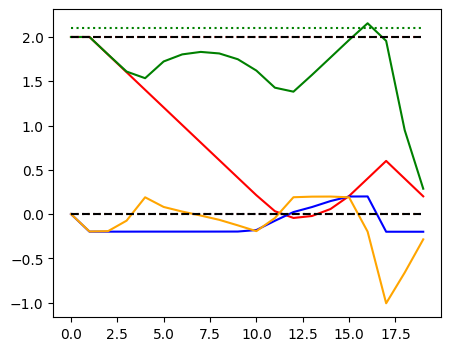

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

final_states, final_inputs = solution.value

# Plot trajectories
pseudotime = jnp.arange(num_timepoints)

labels = ["x1", "v1", "x2", "v2"]
colors = ["red", "blue", "green", "orange"]
for state, label, color in zip(final_states.T, labels, colors):
    ax.plot(pseudotime, state, label=label, color=color)

for state, label, color in zip(states.T, labels, colors):
    ax.plot(pseudotime, state, label=label, color=color, linestyle=":")

ax.plot(pseudotime, 2 * jnp.ones_like(pseudotime), "k--", label="initial_position")
ax.plot(pseudotime, jnp.zeros_like(pseudotime), "k--", label="target")

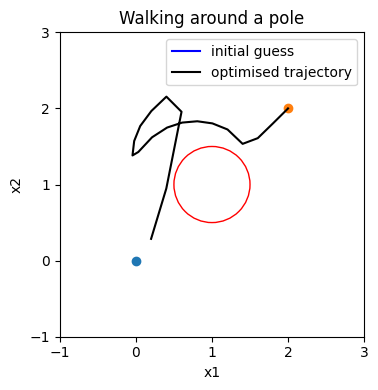

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(states[:, 0], states[:, 2], "b", label="initial guess")
ax.plot(final_states[:, 0], final_states[:, 2], "k-", label="optimised trajectory")

circle = plt.Circle(centerpoint, 0.5, color="r", fill=False)
ax.add_artist(circle)

ax.scatter(0, 0)
ax.scatter(2, 2)

limits = (-1, 3)
ax.set_xlim(limits)
ax.set_ylim(limits)

ax.set_aspect("equal")
ticks = [-1, 0, 1, 2, 3]
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_title("Walking around a pole")

ax.legend()
fig.tight_layout()

(20,)
[-6.37291775e-10 -9.08019493e-10 -1.12608500e-09 -1.58118782e-09] [ 2.07237005e-11 -1.80374882e-11  2.15237828e-11 -1.86272664e-11]


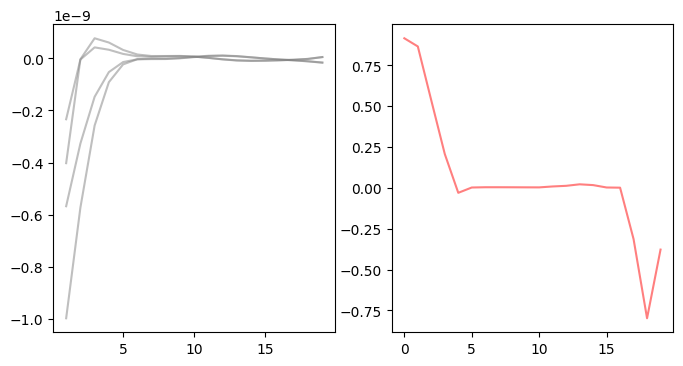

In [17]:
equality_constraints, inequality_constraints = constraint(solution.value)

initial_state, continuity, target_reached = equality_constraints
speed_limit, distance = inequality_constraints
print(distance.shape)

# Plot constraints
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))

for state_continuity in continuity.T:
    ax1.plot(pseudotime[1:], state_continuity, color="gray", alpha=0.5)

ax2.plot(pseudotime, distance, color="red", alpha=0.5)
# ax2.axhline(0, color="black", linestyle="--", linewidth)

print(initial_state, target_reached)

First, import everything we need

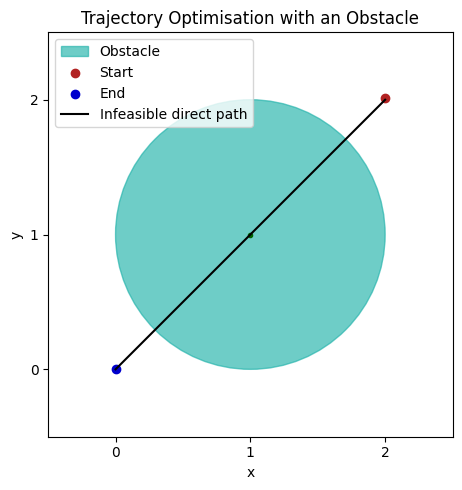

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Add constraint: circle centered at the origin
circle = plt.Circle(
    (1, 1), 1, color="lightseagreen", fill=True, label="Obstacle", alpha=0.65
)
ax.add_patch(circle)
ax.scatter(1, 1, color="darkgreen", marker=".")

ax.scatter(2, 2.01, label="Start", color="firebrick")
ax.scatter(0, 0, label="End", color="mediumblue")

trajectory = jnp.array([[0.0, 0.0], [2.0, 2.0]])
ax.plot([0, 2], [0, 2], color="black", label="Infeasible direct path")
# Plot a naive feasible path

limits = (-0.5, 2.5)
ticks = [0, 1, 2]
ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.legend(loc="upper left")

ax.set_title("Trajectory Optimisation with an Obstacle")

fig.tight_layout()